<img align=center src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT2RkpDnU0khR-RsIgLQcCKUMwM3EbWiFN_5Q&usqp=CAU"></img>
<h2 align=center> Punctuation Restoration using BiLSTMs with Keras</h2>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

### Task 1: Project Overview and Import Modules

In [1]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(0)
plt.style.use("ggplot")

print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.2.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the TED transcription Dataset


*Essential info about punctuation tags*:
- , = comma
- ! = exclamation mark
- . = dot
- ? = question mark


In [2]:
transcript_df = pd.read_csv("/content/drive/My Drive/projects/Punctuation Restoration/transcripts.csv", encoding="utf-8")
transcript_df = transcript_df.fillna(method="ffill")
transcript_df.head(20)

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...
5,Thank you. I have to tell you I'm both challen...,https://www.ted.com/talks/tony_robbins_asks_wh...
6,"On September 10, the morning of my seventh bir...",https://www.ted.com/talks/julia_sweeney_on_let...
7,I'm going to present three projects in rapid f...,https://www.ted.com/talks/joshua_prince_ramus_...
8,It's wonderful to be back. I love this wonderf...,https://www.ted.com/talks/dan_dennett_s_respon...
9,"I'm often asked, ""What surprised you about the...",https://www.ted.com/talks/rick_warren_on_a_lif...


In [3]:
%time transcript_df.transcript = transcript_df.transcript.apply(lambda x: re.sub(r'\([^)]*\)', ' ', x))
%time transcript_df.transcript = transcript_df.transcript.apply(lambda x: re.sub(r'(?<=[.,?!])(?=[^\s])', ' ', x))
%time transcript_df.transcript = transcript_df.transcript.apply(lambda x: x.replace('"', ''))
%time transcript_df.transcript = transcript_df.transcript.apply(lambda x: x.replace("'", ''))

CPU times: user 47.1 ms, sys: 16.8 ms, total: 64 ms
Wall time: 64.4 ms
CPU times: user 729 ms, sys: 7.05 ms, total: 736 ms
Wall time: 740 ms
CPU times: user 37.3 ms, sys: 3.04 ms, total: 40.3 ms
Wall time: 40.1 ms
CPU times: user 35.1 ms, sys: 5.97 ms, total: 41.1 ms
Wall time: 41 ms


In [4]:
text_list = []
sentence_list = []
word_list = []

start = datetime.now()
for i, sentence in tqdm(enumerate(transcript_df.transcript)):
  for word in sentence.split():
      sentence_list.append(f"Sentence: {i}")
      if word.endswith(','):
          word_list.append(word[:-1])
          text_list.append(',')
      elif word.endswith('.'):
          word_list.append(word[:-1])
          text_list.append('.')
      elif word.endswith('?'):
          word_list.append(word[:-1])
          text_list.append('?')
      elif word.endswith('!'):
          word_list.append(word[:-1])
          text_list.append('!')
      else:
          word_list.append(word)
          text_list.append('O')

print(f"Time taken: {datetime.now() - start}")
data = pd.DataFrame({'Sentence #': sentence_list, 'Word': word_list, 'Tag': text_list})
print(f"Dataset shape: {data.shape}")

2467it [00:06, 410.86it/s]


Time taken: 0:00:06.010795
Dataset shape: (5086851, 3)


In [5]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 87371
Unique tags in corpus: 5


In [6]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [7]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [8]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [9]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [25]:
sentences[0][:20]

[('Good', 'O'),
 ('morning', '.'),
 ('How', 'O'),
 ('are', 'O'),
 ('you', '?'),
 ('Its', 'O'),
 ('been', 'O'),
 ('great', ','),
 ('hasnt', 'O'),
 ('it', '?'),
 ('Ive', 'O'),
 ('been', 'O'),
 ('blown', 'O'),
 ('away', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('whole', 'O'),
 ('thing', '.'),
 ('In', 'O'),
 ('fact', ',')]

### Task 4: Define Mappings between Sentences and Tags

In [11]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [13]:
tag2idx

{'!': 2, ',': 1, '.': 4, '?': 0, 'O': 3}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

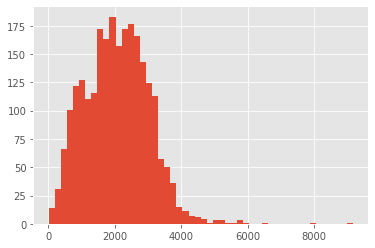

In [14]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"Train size: {len(x_train)}, \nTest size: {len(x_test)}")

Train size: 1967, 
Test size: 492


### Task 6: Build and Compile a Bidirectional LSTM Model

In [17]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional, Dropout

In [18]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
# model = SpatialDropout1D(0.1)(model)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=200, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            4368600   
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 400)           401600    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 5)             2005      
Total params: 4,772,205
Trainable params: 4,772,205
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Task 7: Train the Model

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [21]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='min', baseline=None, restore_best_weights=False)

callbacks = [chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
62/62 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.8321
Epoch 00001: val_loss improved from inf to 0.54075, saving model to model_weights.h5
62/62 [==============================] - 32s 514ms/step - loss: 0.6846 - accuracy: 0.8321 - val_loss: 0.5407 - val_accuracy: 0.8434
Epoch 2/30
62/62 [==============================] - ETA: 0s - loss: 0.5080 - accuracy: 0.8498
Epoch 00002: val_loss improved from 0.54075 to 0.46930, saving model to model_weights.h5
62/62 [==============================] - 31s 505ms/step - loss: 0.5080 - accuracy: 0.8498 - val_loss: 0.4693 - val_accuracy: 0.8612
Epoch 3/30
62/62 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.8644
Epoch 00003: val_loss improved from 0.46930 to 0.39567, saving model to model_weights.h5
62/62 [==============================] - 31s 499ms/step - loss: 0.4089 - accuracy: 0.8644 - val_loss: 0.3957 - val_accuracy: 0.8710
Epoch 4/30
62/62 [==============================] - ETA: 0s

### Task 8: Evaluate Punctuation Restoration Model

In [22]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 1s 45ms/step - loss: 0.2624 - accuracy: 0.9183


[0.2623521089553833, 0.9183333516120911]

In [24]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
longevity      O	,
there          O	O
is             O	O
no             O	O
short          O	O
term           O	O
fix            O	O
in             O	O
a              O	O
pill           O	O
or             O	O
anything       O	O
else           .	.
But            O	O
when           O	O
you            O	O
think          O	O
about          O	O
it             ,	O
your           O	O
friends        O	O
are            O	O
long-term      O	O
adventures     ,	,
and            O	O
therefore      ,	,
perhaps        O	O
the            O	O
most           O	O
significant    O	O
thing          O	O
you            O	O
can            O	O
do             O	O
to             O	O
add            O	O
more           O	O
years          O	O
to             O	O
your           O	O
life           ,	,
and            O	O
life           O	O
to             O	O
your           O	O
years          .	.
Thank          O	O
you            O	O
very           O	O
much      